epoch: 0 | d_loss: 0.9944344758987427 | g_loss: 0.5579267144203186
epoch: 200 | d_loss: 0.43001726269721985 | g_loss: 1.0725700855255127
epoch: 400 | d_loss: 0.5524593591690063 | g_loss: 1.552762746810913
epoch: 600 | d_loss: 1.0185649394989014 | g_loss: 1.2711907625198364
epoch: 800 | d_loss: 1.3797557353973389 | g_loss: 0.8737785816192627
epoch: 1000 | d_loss: 1.4164334535598755 | g_loss: 0.7865729331970215
epoch: 1200 | d_loss: 1.3952118158340454 | g_loss: 0.79208904504776
epoch: 1400 | d_loss: 1.3871972560882568 | g_loss: 0.7370116710662842


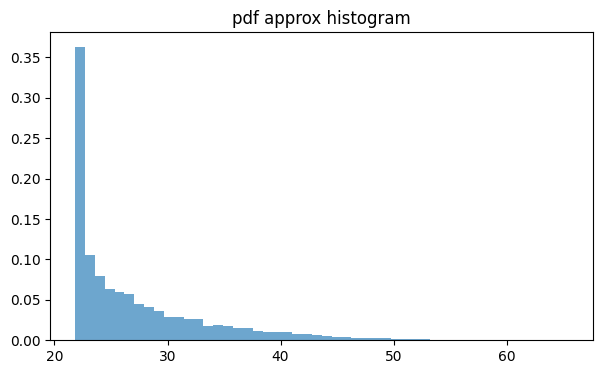

In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

df = pd.read_csv("data.csv",sep=None,engine='python',encoding='latin1')
x = df['no2'].dropna().values.astype(np.float32)
r = 102303847
a = 0.5 * (r % 7)
b = 0.3 * ((r % 5) + 1)
#z = x + a*sin(bx)
z = x + a * np.sin(b*x)
z = z.reshape(-1,1)
z = torch.tensor(z).float()
#generator
G_W1 = nn.Linear(1, 16)
G_W2 = nn.Linear(16, 1)
G_act = nn.ReLU()
#discriminator
D_W1 = nn.Linear(1, 16)
D_W2 = nn.Linear(16, 1)
D_act = nn.LeakyReLU(0.2)
D_sig = nn.Sigmoid()
#optimizers
opt_G = optim.Adam(list(G_W1.parameters()) + list(G_W2.parameters()), lr=1e-3)
opt_D = optim.Adam(list(D_W1.parameters()) + list(D_W2.parameters()), lr=1e-3)
loss_fn = nn.BCELoss()

for epoch in range(1500):
    #real batch
    idx = np.random.randint(0, z.size(0), 256)
    real = z[idx]
    #labels
    ones = torch.ones((256,1))
    zeros = torch.zeros((256,1))
    #fake batch
    noise = torch.randn((256,1))
    fake = G_W2(G_act(G_W1(noise)))
    #discriminator update
    out_real = D_sig(D_W2(D_act(D_W1(real))))
    out_fake = D_sig(D_W2(D_act(D_W1(fake.detach()))))
    loss_D = loss_fn(out_real, ones) + loss_fn(out_fake, zeros)
    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()
    #generator update
    out_fake2 = D_sig(D_W2(D_act(D_W1(fake))))
    loss_G = loss_fn(out_fake2, ones)
    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()
    if epoch % 200 == 0:
        print("epoch:", epoch, "| d_loss:", float(loss_D), "| g_loss:", float(loss_G))

with torch.no_grad():
    noise = torch.randn((10000,1))
    z_fake = G_W2(G_act(G_W1(noise))).numpy().flatten()
#pdf approx histogram
plt.figure(figsize=(7,4))
plt.hist(z_fake, bins=50, density=True, alpha=0.65)
plt.title("pdf approx histogram")
plt.show()
